In [1]:
import pandas as pd
import numpy as np
from surprise import SVD, Dataset, Reader, KNNBasic, KNNWithMeans
from surprise.model_selection import train_test_split
from surprise import accuracy
import matplotlib.pyplot as plt
import seaborn as sns


## Project 2
In this project, the Jester dataset is used to train and generate top 5 joke recommendations for a specific user.
Due to the shear volume, we will be randomly selecting only 100 jokes and use user-item collaborative filtering (CF), specifically comparing user-user and item-item CF with normalized and un-normalized data.

### Loading and randomly selecting only 100 samples from the jester dataset:
Rating scale = -10 to 10

In [2]:
url='https://raw.githubusercontent.com/stormwhale/data-mines/refs/heads/main/jester-data-3.csv'

jokes = pd.read_csv(url, header=None)

#We will sample only 100 ratings for faster training:
jokes100 = jokes.sample(100, random_state=42)

#Removing the first column as it is not needed for the model:
jokes100 =jokes100.drop(columns=[0])

#the value 99 is used to indicate that the user did not rate the joke:
#We will replace those values with NaN:
jokes100 = jokes100.replace(99, np.nan)

#Visualize the data:
jokes100.head(5)

,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
3995,NaN,NaN,NaN,NaN,-2.82,NaN,-0.83,-3.16,NaN,NaN,...,2.04,NaN,1.26,NaN,NaN,-0.63,NaN,NaN,NaN,NaN
18976,NaN,NaN,NaN,NaN,2.52,NaN,6.80,2.48,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17462,NaN,NaN,NaN,NaN,-4.85,NaN,-7.43,-7.86,NaN,NaN,...,-8.30,NaN,NaN,NaN,NaN,NaN,NaN,-9.95,NaN,NaN
16367,NaN,NaN,NaN,NaN,-1.12,NaN,0.58,-3.74,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,3.54,NaN,NaN,NaN,NaN
17752,NaN,NaN,NaN,NaN,-9.08,NaN,-8.06,-7.33,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-6.8,NaN,NaN,NaN


### To rename the columns and rows:

In [3]:
#To name the columns:
jokes100.columns = [f'j{i}' for i in range(1,100)] + ['userID']

#To add the userID column:
jokes100['userID'] = range(1, len(jokes100)+1)

### Converting the dataframe to a long format:

In [4]:
#Converting the DataFrame to a long format:
joke100_long = jokes100.melt(id_vars='userID', var_name='jokesID', value_name='rating')

#Remove rows with NaN values:
joke100_long_no_na = joke100_long.dropna()

#No confirm if NA values left:
joke100_long_no_na.isna().sum()


userID     0
jokesID    0
rating     0
dtype: int64

In [5]:
joke100_long_no_na.head(5)

,userID,jokesID,rating
121,22,j2,-3.98
133,34,j2,0.97
400,1,j5,-2.82
401,2,j5,2.52
402,3,j5,-4.85


### Exploratory data:

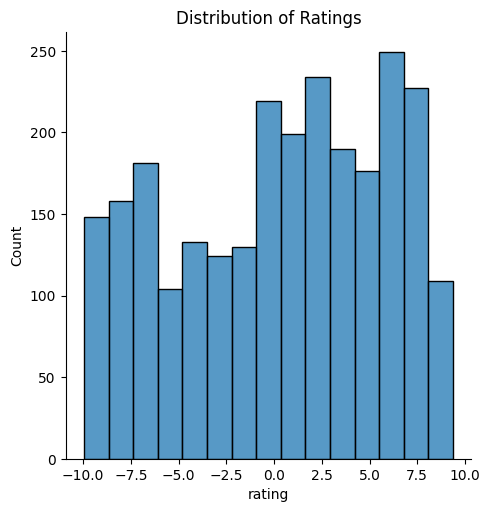

In [6]:
sns.displot(joke100_long_no_na['rating'])
plt.title('Distribution of Ratings')
plt.show()

The ratings has a slight left skewness. Let's try to normalize the data to improve the distribution.

### To normalize the Data:

In [7]:
#Finding the mean rating for each user:
jk_mean = joke100_long_no_na.groupby('userID')['rating'].mean().reset_index()
joke100_norm = joke100_long_no_na.merge(jk_mean, on='userID', suffixes=('', '_mean'))
joke100_norm['normalized_rating'] = joke100_norm['rating'] - joke100_norm['rating_mean']

In [8]:
joke100_norm.head()

,userID,jokesID,rating,rating_mean,normalized_rating
0,22,j2,-3.98,-3.823824,-0.156176
1,34,j2,0.97,-1.379697,2.349697
2,1,j5,-2.82,-0.162500,-2.657500
3,2,j5,2.52,2.226800,0.293200
4,3,j5,-4.85,-4.567391,-0.282609


### Viewing the rating histogram after normalization:

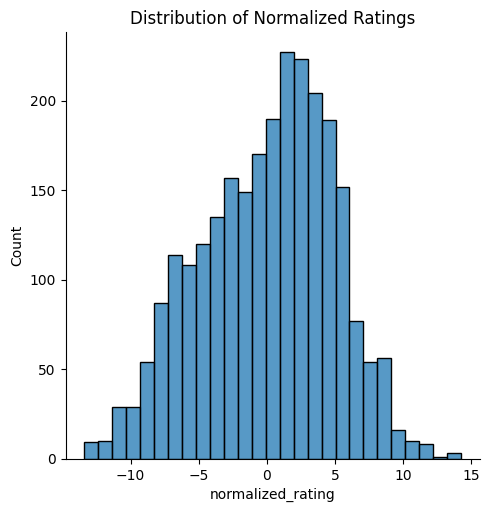

In [9]:
sns.displot(joke100_norm['normalized_rating'])
plt.title('Distribution of Normalized Ratings')
plt.show()

### Use Surprise library to compute the user-based collabrative filtering:

In [10]:
#loading data into Surprise format:
reader = Reader(rating_scale=(-10, 10))
#Creating a Surprise dataset from the DataFrame:
data = Dataset.load_from_df(joke100_long_no_na[['userID', 'jokesID', 'rating']], reader)


### Split data and define the model:

In [11]:
#Splitting the dataset into training and testing sets:
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

#Define the parameters of the KNN model with Cosine similary and user-user collaborative filtering:
sim_opt = {
    'name': 'cosine',
    'user_based': True,
    'min_support': 2}# Compute similarities between users
 

#Define the KNNBasic without normalization:
algo = KNNBasic(sim_options=sim_opt)
algo.fit(trainset)

#Define normalized user-user collaborative filtering model:
algo_norm = KNNWithMeans(sim_options=sim_opt) #We can use KNNWithMeans
algo_norm.fit(trainset)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.


### To make prediction:

In [12]:
#Predictions for un-normalized model:
predictions = algo.test(testset)
rmse = accuracy.rmse(predictions, verbose=False)

#Predictions for normalized model:
predictions_norm = algo_norm.test(testset)
rmse_norm = accuracy.rmse(predictions_norm, verbose=False)
print(f'RMSE for un-normalized model: {rmse:.3f}\nRMSE for normalized model: {rmse_norm:.3f}')

RMSE for un-normalized model: 5.068
RMSE for normalized model: 4.818


The normalized data showed better RMSE than the un-normalized data. We will implement normalized data.

### To predict the top 5 jokes that user1 will likely enjoy:

In [13]:
#Define a function to get top 5 jokes for a user based on the normalized model:
def get_top_5_jokes(algo_norm, user_id, joke_list, known_jokes, n=5):
    """# known_jokes = set of jokes user has already rated

    # Predict rating for each joke the user hasn't rated yet
    """
    prediction = []
    for joke_id in joke_list:
        if joke_id not in known_jokes:
            pred = algo_norm.predict(user_id, joke_id)
            prediction.append((joke_id, pred.est))
    # Sort predictions by estimated rating in descending order
    prediction.sort(key = lambda x: x[1], reverse=True)
    return prediction[:n]

#Define target user:
user_id=1

#To get all jokeIDs only:
all_jokes = joke100_long['jokesID'].unique()

user_id=1
user_rated_jokes = set(
    joke100_long[
        (joke100_long['userID'] == user_id) &
        (joke100_long['rating'].notna())
    ]['jokesID']
)

# Generate top 5 recommendations
top_5 = get_top_5_jokes(algo_norm, user_id, all_jokes, user_rated_jokes, n=5)
#To print the top 5 jokes:
for i, (joke_id, est_rating) in enumerate(top_5, start=1):
    print(f'Joke {joke_id} with estimated rating: {est_rating:.3f}')

Joke j40 with estimated rating: 6.438
Joke j72 with estimated rating: 6.054
Joke j87 with estimated rating: 4.322
Joke j38 with estimated rating: 4.043
Joke j88 with estimated rating: 3.919


To predict a joke rating for User1 and joke40, which was not rated by user1.
We will also recommend top 5 jokes that user1 might potentially like as rated by users who are similar to user1

In [14]:
#Let's predict the rating for j1 for user 1:
userID = 1
jokesID = 'j40'
predicted_rating = algo_norm.predict(userID, jokesID).est
print(f'User1 will potentially rate joke40: {predicted_rating:.3f}')

User1 will potentially rate joke40: 6.438


The signle prediction confirms with the top recommending jokes estimated rating score.

### Item-item collaborative filtering for jokes

In [18]:
#Define the sim_opt:
sim_opt_item = {
    'name': 'cosine', #Use cosine similarity
    'user_based': False,
    'min_support': 2 # setting min_support to 2 means that an item must be rated by at least 2 users to be considered in the similarity calculation
}

#Define the KNN model with normalization:
algo_item_norm = KNNWithMeans(sim_options=sim_opt_item)
#Fit the model:
algo_item_norm.fit(trainset)
#Predictions for the item-based normalized model:
predictions_item_norm = algo_item_norm.test(testset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [19]:
#Generate RMSE for the item-based normalized model:
rmse_item_norm = accuracy.rmse(predictions_item_norm, verbose=False)
print(f'RMSE for item-based normalized model: {rmse_item_norm:.3f}')

RMSE for item-based normalized model: 4.822


### Checking to see if item-item CF will generate the same top 5 jokes for user1

In [20]:
#Define a new function to get top 5 jokes for a user based on the item-based normalized model:
def get_item_top_5_jokes(algo_item_norm, user_id, joke_list, known_jokes, n=5):
    """# known_jokes = set of jokes user has already rated

    # Predict rating for each joke the user hasn't rated yet
    """
    prediction = []
    for joke_id in joke_list:
        if joke_id not in known_jokes:
            pred = algo_item_norm.predict(user_id, joke_id)
            prediction.append((joke_id, pred.est))
    # Sort predictions by estimated rating in descending order
    prediction.sort(key = lambda x: x[1], reverse=True)
    return prediction[:n]

user_id = 1
user_rated_jokes = set(
    joke100_long[
        (joke100_long['userID'] == user_id) &
        (joke100_long['rating'].notna())
    ]['jokesID']
)
# Generate top 5 recommendations using item-based model
top_5_item = get_item_top_5_jokes(algo_item_norm, user_id, all_jokes, user_rated_jokes, n=5)
for i, (joke_id, est_rating) in enumerate(top_5_item, start=1):
    print(f'Joke {joke_id} with estimated rating: {est_rating:.3f}')

Joke j11 with estimated rating: 6.310
Joke j72 with estimated rating: 5.533
Joke j6 with estimated rating: 5.530
Joke j38 with estimated rating: 5.286
Joke j10 with estimated rating: 5.190


**Summary**:

A user-based collaborative filtering (CF) model was built using a sample of 100 users from the Jester dataset. Cosine similarity was used as the distance metric in the K-Nearest Neighbors (KNN) algorithm to group users or items based on similarity. The principle behind the KNN–cosine similarity approach is to find the k nearest neighbors (either user–user or item–item) based on the directional closeness of their vectors, rather than their magnitude. For instance, if two users rated the same types of jokes highly, their corresponding vectors would point in a similar direction, resulting in a small angle between them and thus a cosine similarity value close to 1 — indicating high similarity. On the other hand, two user vectors with an angle equal to or greater than 90° will result in a cosine similarity of 0 or less, indicating low or negative similarity. This method is particularly effective for handling high-dimensional or sparse datasets. Additionally, it is not affected by rating scale bias, where two users may have similar preferences but differ in rating intensity (e.g., one rates more harshly than the other).

While KNN with cosine similarity is widely used, it has its own limitations depending on the properties of the dataset. First, in prediction tasks that are sensitive to rating scale or magnitude, this method may be suboptimal because it considers only the direction of the vectors. Second, in extremely sparse user–item matrices, a single overlapping rating between two users or items can result in an artificially high similarity score, due to lack of data. This issue often arises in item–item collaborative filtering, as shown in the earlier example. To mitigate this, we can set the min_support parameter to a minimum threshold N, requiring that a pair of vectors must share at least N overlapping ratings before similarity is computed. This ensures that similarities are based on sufficient evidence rather than on coincidental matches.

Two versions of the model were evaluated: one using raw ratings ,and the other using normalized ratings. The model performances were assessed by RMSE. Results showed that the normalized rating model yielded lower RMSE than the raw rating. This difference is likely due to user-bias in the raw data--such as user assigning the same rating to all jokes or rating at the extremes. Normalization helped to reduce such bias by centering the rating as shown by the plot above.

While the RMSE might seem high, this is to be expected from the jester dataset since the rating scale spans from -10 to 10, unlike the more conservative rating scales from only 1 to 5. This boarder scaling introduces higher variability that could impact the RMSE.

The top-5 personalized joke recommendation was also generated for user1. Joke 40(j40) was ranked the most highly rated according to the user-based CF. A separate prediction for j40 was also predicted to have the same estimated rating as the top-5 recommended jokes, suggesting consistency in the user-based recommendation logic.

An additional, an item-based CF was also built to generate the top-5 joke recommendation for user1 for comparsion. While both methods provided a slightly different top-5 jokes with overlapping recommendation on j38 and j72, the RMSE measured in item-based CF model was slightly higher with slightly higher estimated ratings. This is likely due to the nature of the jester dataset, which allows users to be more expressive and subjective in their joke ratings. Since item-based CF relies on item similarity, and jokes are highly subjective in humor, this approach may be less efftive than grouping users with similar rating behaviors.

In this context, the user-based CF with normalization proved tp be the better recommender system, making it more suitable for the Jester dataset. For further refinement of the recommender system, we can try to use singular value decomposition (SVD) to simplify the user-item matrix and machine learning to yield a better prediction.